<a href="https://colab.research.google.com/github/KRiver28/TIL/blob/master/RNN_CNN(mnist).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Reshape
from tensorflow.keras.layers import MaxPooling2D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt


In [119]:
mnist = load_digits()
print(mnist.data.shape)

(1797, 64)


In [120]:
# # mnist['data'] 숫자의 범위를 변환한다 (표준화) : 0 ~ 255 --> 0 ~ 1.0
# # target = ['1', '2',...] 문자로 돼있음. --> 숫자로 변환해야 함.
# x_feat = np.array(mnist['data']).reshape(-1, 28, 28) / 255
# y_target = np.array(mnist['target'].to_numpy().astype('int8')).reshape(-1,1)

In [121]:
# mnist['data'] 숫자의 범위를 변환한다 (표준화) : 0 ~ 255 --> 0 ~ 1.0
# target = ['1', '2',...] 문자로 돼있음. --> 숫자로 변환해야 함.
x_feat = np.array(mnist['data']).reshape(-1,16, 4) / 255
y_target = np.array(mnist['target'].astype('int8')).reshape(-1,1)

# 학습 데이터와 시험 데이터를 생성한다.
x_train, x_test, y_train, y_test = train_test_split(x_feat, y_target, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1437, 16, 4), (360, 16, 4), (1437, 1), (360, 1))

In [122]:
# Convolutional 2D 모델을 생성한다.
n_row = x_train.shape[1]
n_col = x_train.shape[2]
n_chan = 1
n_class = len(set(y_train[:, 0]))
n_hidden = 50

In [123]:
# 입력
x_input = Input(batch_shape = (None, n_row, n_col))

In [124]:
# LSTM
h_rnn = LSTM(n_hidden)(x_input)

In [125]:
# CNN
x_input_cnn = Reshape((n_row, n_col, n_chan))(x_input)
h_conv = Conv2D(filters=10, kernel_size=(6, 4), strides=1, padding = 'valid', activation='relu')(x_input_cnn)
h_pool = MaxPooling2D(pool_size=(4,1), strides=1, padding='valid')(h_conv)
h_flat = Flatten()(h_pool)
h_cnn = Dense(n_hidden, activation='tanh')(h_flat)

In [126]:
# combine
h_concat = Concatenate()([h_rnn, h_cnn])

y_output = Dense(n_class, activation='softmax')(h_concat)

model = Model(x_input, y_output)
model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 16, 4)]      0           []                               
                                                                                                  
 reshape_42 (Reshape)           (None, 16, 4, 1)     0           ['input_7[0][0]']                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 11, 1, 10)    250         ['reshape_42[0][0]']             
                                                                                                  
 max_pooling2d_37 (MaxPooling2D  (None, 8, 1, 10)    0           ['conv2d_42[0][0]']              
 )                                                                                          

In [127]:
hist = model.fit(x_train, y_train, 
                 batch_size=1024, 
                 epochs=50, 
                 validation_data = (x_test, y_test))

Epoch 1/50
2/2 [==============================] - 2s 541ms/step - loss: 2.3025 - val_loss: 2.3005
Epoch 2/50
2/2 [==============================] - 0s 73ms/step - loss: 2.3001 - val_loss: 2.2987
Epoch 3/50
2/2 [==============================] - 0s 71ms/step - loss: 2.2978 - val_loss: 2.2968
Epoch 4/50
2/2 [==============================] - 0s 71ms/step - loss: 2.2954 - val_loss: 2.2947
Epoch 5/50
2/2 [==============================] - 0s 72ms/step - loss: 2.2930 - val_loss: 2.2926
Epoch 6/50
2/2 [==============================] - 0s 68ms/step - loss: 2.2904 - val_loss: 2.2903
Epoch 7/50
2/2 [==============================] - 0s 67ms/step - loss: 2.2879 - val_loss: 2.2878
Epoch 8/50
2/2 [==============================] - 0s 76ms/step - loss: 2.2853 - val_loss: 2.2852
Epoch 9/50
2/2 [==============================] - 0s 69ms/step - loss: 2.2826 - val_loss: 2.2822
Epoch 10/50
2/2 [==============================] - 0s 71ms/step - loss: 2.2797 - val_loss: 2.2790
Epoch 11/50
2/2 [===========

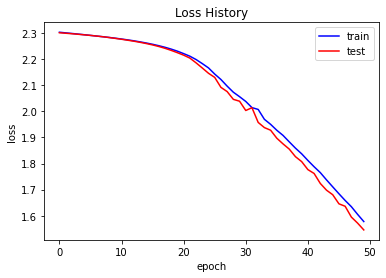

In [128]:
# Loss history를 그린다
plt.plot(hist.history['loss'], color='blue', label='train')
plt.plot(hist.history['val_loss'], color='red', label='test')
plt.legend()
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [129]:
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1).reshape(-1,1)
acc = (y_test == y_pred).mean()
print('정확도 ={:.4f}'.format(acc))

정확도 =0.6083


In [130]:
import pandas as pd
df = pd.DataFrame({'y_test': y_test.reshape(-1,), 'y_pred': y_pred.reshape(-1,)})
df.head(10)

,y_test,y_pred
0,4,4
1,8,1
2,6,6
3,6,4
4,1,1
5,7,5
6,9,3
7,0,5
8,7,1
9,8,9


In [131]:
# 잘못 분류한 이미지 몇개를 확인해 본다.
# 어떤 이미지를 잘 맞추지 못할까? 사람이라면 아래 이미지를 잘 맞출 수 있을까?
n_sample = 10
miss_cls = np.where(y_test != y_pred)[0]
miss_sam = np.random.choice(miss_cls, n_sample)

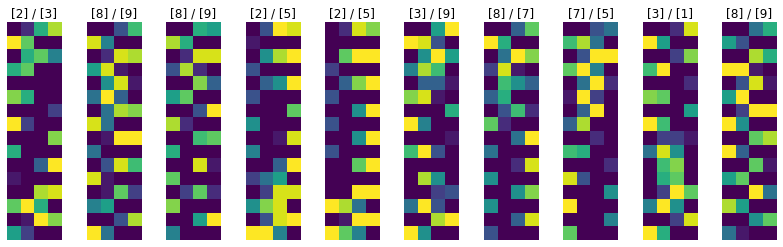

In [132]:
fig, ax = plt.subplots(1, n_sample, figsize=(14,4))
for i, miss in enumerate(miss_sam):
    x = x_test[miss] * 255  # 표준화 단계에서 255로 나누었으므로, 여기서는 곱해준다.
    ax[i].imshow(x)
    ax[i].axis('off')
    ax[i].set_title(str(y_test[miss]) + ' / ' + str(y_pred[miss]))